### lightGBM on data with seasonality

In [1]:
from darts.models.forecasting.lgbm import LightGBMModel
from darts import TimeSeries

from darts.utils.statistics import extract_trend_and_seasonality, check_seasonality

Support for Torch based models not available. To enable them, install "darts", "u8darts[torch]" or "u8darts[all]" (with pip); or "u8darts-torch" or "u8darts-all" (with conda).
/home/mahdi/anaconda3/envs/darts/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd
#df = pd.read_csv('datasets/air_quality/BeijingPM25_0.csv')
df = pd.read_csv('datasets/retail/air_passengers.csv')

In [3]:
len(df)

144

In [4]:
df.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [5]:
df.tail(12)

,ds,y
132,1960-01-01,417
133,1960-02-01,391
134,1960-03-01,419
135,1960-04-01,461
136,1960-05-01,472
137,1960-06-01,535
138,1960-07-01,622
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461


<Axes: xlabel='ds'>

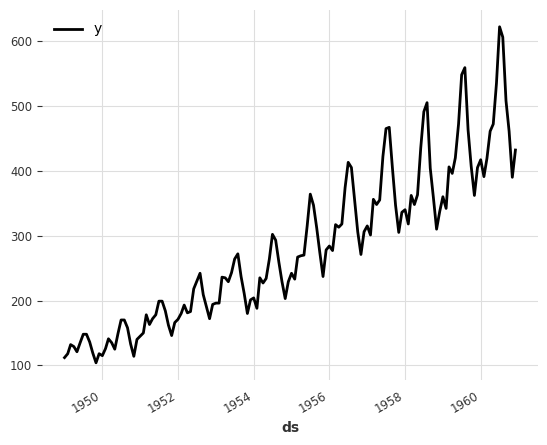

In [6]:
target_series = TimeSeries.from_dataframe(df, 'ds', 'y')

target_series.plot()

### Seasonality-Related Processing

In [7]:
check_seasonality(target_series)

(True, 12)

In [8]:
#check_seasonality(target_series_diff)

In [9]:
from darts.utils.utils import ModelMode
tmp = extract_trend_and_seasonality(target_series, model=ModelMode.MULTIPLICATIVE)#, method='STL'
target_series_trend, target_series_seasonal = tmp[0], tmp[1]

#TODO: What about additive decomposition?

target_series_irregular = target_series / (target_series_trend * target_series_seasonal)

### Decomposition

In [10]:
from darts.dataprocessing.transformers import Diff

difference_transformer = Diff(lags=1, dropna=True)

In [11]:
num_test = 12


### Split trend component into train and test

In [12]:
target_series_trend_train, target_series_trend_test = \
    target_series_trend[:-num_test], target_series_trend[-num_test:]



### Difference the train and test components of trend

In [13]:
#target_series_trend_diff = difference_transformer.fit_transform(target_series_trend)
#target_series_trend_diff_train, target_series_trend_diff_test = \
#    target_series_trend_diff[:-num_test], target_series_trend_diff[-num_test:]


target_series_trend_train_diff = difference_transformer.fit_transform(target_series_trend_train)
target_series_trend_test_diff = difference_transformer.transform(target_series_trend_test)

<Axes: xlabel='ds'>

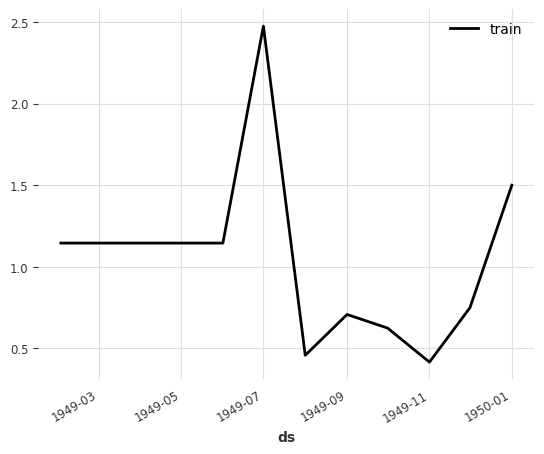

In [14]:
target_series_trend_train_diff[0:12].plot(label='train')

<Axes: xlabel='ds'>

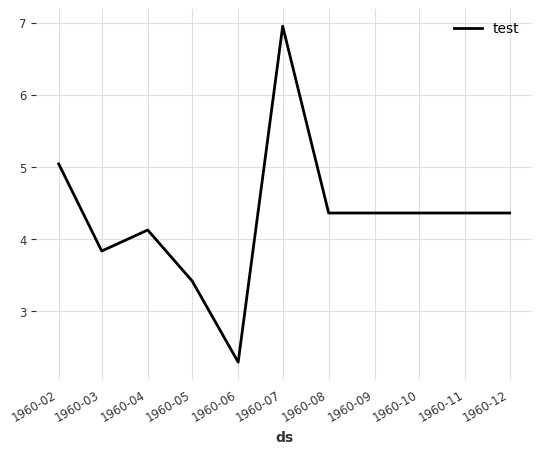

In [15]:
target_series_trend_test_diff.plot(label='test')

In [16]:
target_series_seasonal_train, target_diff_series_seasonal_test = \
    target_series_seasonal[:-num_test], target_series_seasonal[-num_test:]

target_series_irregular_train, target_series_irregular_test = \
    target_series_irregular[:-num_test], target_series_irregular[-num_test:]

In [17]:
n_lags = num_test
model_trend = LightGBMModel(lags=n_lags, output_chunk_length=num_test)#, max_depth=4, n_estimators=10)
model_seasonal = LightGBMModel(lags=n_lags, output_chunk_length=num_test)
model_irregular = LightGBMModel(lags=n_lags, output_chunk_length=num_test)

In [18]:
model_trend.fit(series=target_series_trend_train_diff)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 425
[LightGBM] [Info] Number of data points in the train set: 108, number of used features: 12
[LightGBM] [Info] Start training from score 2.511960
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

LightGBMModel(lags=12, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=12, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True, categorical_past_covariates=None, categorical_future_covariates=None, categorical_static_covariates=None)

In [19]:
model_seasonal.fit(series=target_series_seasonal_train)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 156
[LightGBM] [Info] Number of data points in the train set: 109, number of used features: 12
[LightGBM] [Info] Start training from score 0.999186
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

LightGBMModel(lags=12, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=12, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True, categorical_past_covariates=None, categorical_future_covariates=None, categorical_static_covariates=None)

In [20]:
model_irregular.fit(series=target_series_irregular_train)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 456
[LightGBM] [Info] Number of data points in the train set: 109, number of used features: 12
[LightGBM] [Info] Start training from score 0.999312
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

LightGBMModel(lags=12, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=12, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True, categorical_past_covariates=None, categorical_future_covariates=None, categorical_static_covariates=None)

In [21]:
tmp_trend_pred = model_trend.predict(num_test)

In [22]:
tmp_seasonal_pred = model_seasonal.predict(num_test)

<Axes: xlabel='ds'>

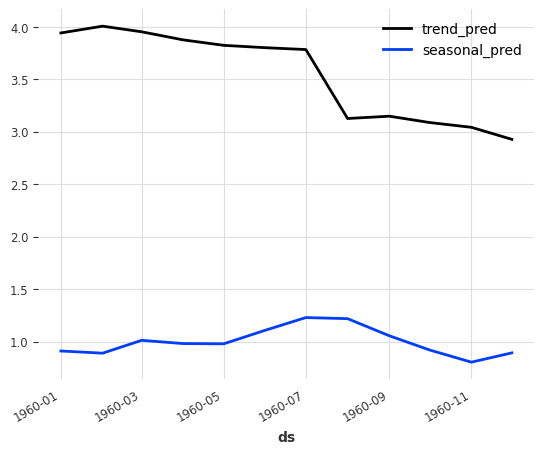

In [23]:
tmp_trend_pred.plot(label='trend_pred')
tmp_seasonal_pred.plot(label='seasonal_pred')

In [24]:
tmp = difference_transformer.inverse_transform(target_series_trend_train_diff.concatenate(model_trend.predict(num_test)))
target_series_trend_test_pred = tmp[-num_test:]

target_series_seasonal_test_pred = model_seasonal.predict(num_test)
target_series_irregular_test_pred = model_irregular.predict(num_test)

<Axes: xlabel='ds'>

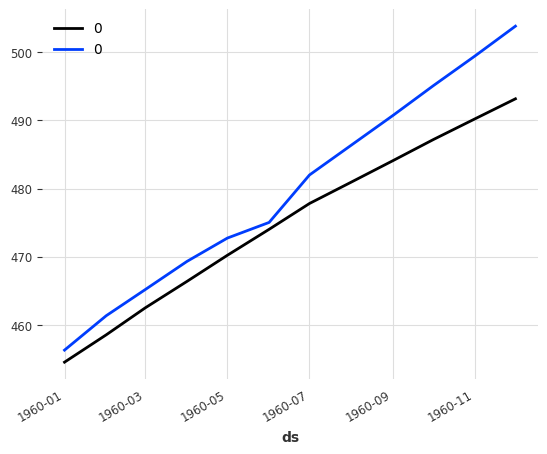

In [25]:
target_series_trend_test_pred.plot()
target_series_trend_test.plot()

In [26]:
target_series_train, target_series_test = target_series[:-num_test], target_series[-num_test:]

<Axes: xlabel='time'>

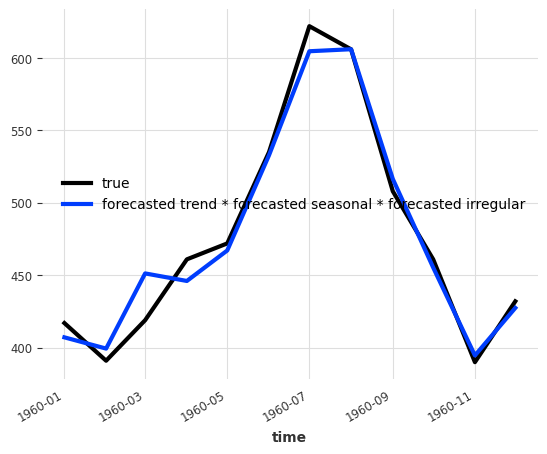

In [27]:
#target_series_train.plot(label='training')
#target_series_test.plot(label='true', lw=3)
target_series_test.plot(label='true', lw=3)

target_series_test_reconstructed_pred = \
    target_series_trend_test_pred*target_series_seasonal_test_pred*target_series_irregular_test_pred

target_series_test_reconstructed_pred.plot(label='forecasted trend * forecasted seasonal * forecasted irregular', lw=3)

<Axes: xlabel='time'>

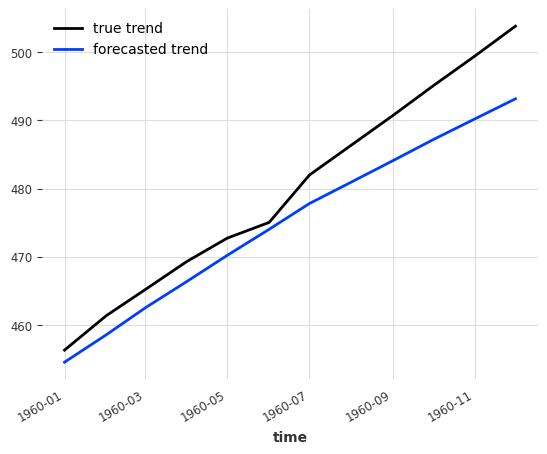

In [28]:
target_series_trend_test.plot(label='true trend')
target_series_trend_test_pred.plot(label='forecasted trend')